In [105]:
import os
import requests
import pandas as pd
import time
import datetime
from pathlib import Path
from panel.interact import interact
import plotly.express as px
import panel as pn

In [106]:
# Read history from csv
history_data = Path("data/data_5year.csv")
history_df = pd.read_csv(history_data, parse_dates=True, infer_datetime_format=True)

# clean unused column from dataframe
if 'Unnamed: 0' in history_df.columns:
    history_df = history_df.drop(['Unnamed: 0'], axis=1)

In [107]:
def pivot_price_dataframe(history_df, ticker_list, ticker_header=None, price_header=None):
    
    price_df = None
    unwanted_tickers = []
    
    try:
        
        # Test if ticker_header suppied exists, and looks for a default header if not
        
        if not ticker_header in list(history_df.columns):
            if "Ticker" in list(history_df.columns):
                ticker_header = "Ticker"
            elif "ticker" in list(history_df.columns):
                ticker_header = "ticker"
            else:
                 raise ValueError(f"No ticker column found")
    
        if not price_header in list(history_df.columns):
            if "Price" in list(history_df.columns):
                price_header = "Price"
            elif "price" in list(history_df.columns):
                price_header = "price"
            else:
                raise ValueError(f"No price column found")
        
        existing_tickers = history_df[ticker_header].unique()
        
        # test if valid tickers are supplied
        
        for ticker in ticker_list:
            if not ticker in list(existing_tickers):
                raise ValueError(f"Ticker \"{ticker}\" does not exist in dataframe")
    
        # Pivot
        price_df = history_df.pivot(index="Date", columns=ticker_header, values=price_header)
    
        # Drop unwanted tickers, so we're only getting those specified by ticker_list
        for ticker in list(price_df.columns):
            if not ticker in ticker_list:
                unwanted_tickers.append(ticker)
        
        price_df = price_df.drop(unwanted_tickers, axis=1)
        
        # Drop NA, and rename columns.name
        price_df = price_df.dropna()
        
        price_df.columns.name = "Price"
        
    except ValueError as err:
        print('Value error: ', err)
    
    return price_df

def daily_returns_dataframe(price_df):
    
    daily_returns = price_df.sort_index(ascending=False).pct_change().dropna()
    
    daily_returns.columns.name = "Daily Returns"
    
    return daily_returns

def cumulative_returns_dataframe(price_df):
    
    # Get daily returns
    daily_returns = daily_returns_dataframe(price_df)
    
    # Calculate cumulative returns
    cumulative_returns = (1 + daily_returns).cumprod()
    
    # Rename column to "Cumulative Returns"
    cumulative_returns.columns.name = "Cumulative Returns"
    
    return cumulative_returns

def cumulative_returns_plot(cumulative_returns_df):
    
    plt = px.line(cumulative_returns_df, labels=dict(x="Date", y="Cumulative Returns", color="Cumulative Returns")) 
        
    plt.update_xaxes(title_text='Date')
    plt.update_yaxes(title_text='Cumulative Returns')
    
    return plt


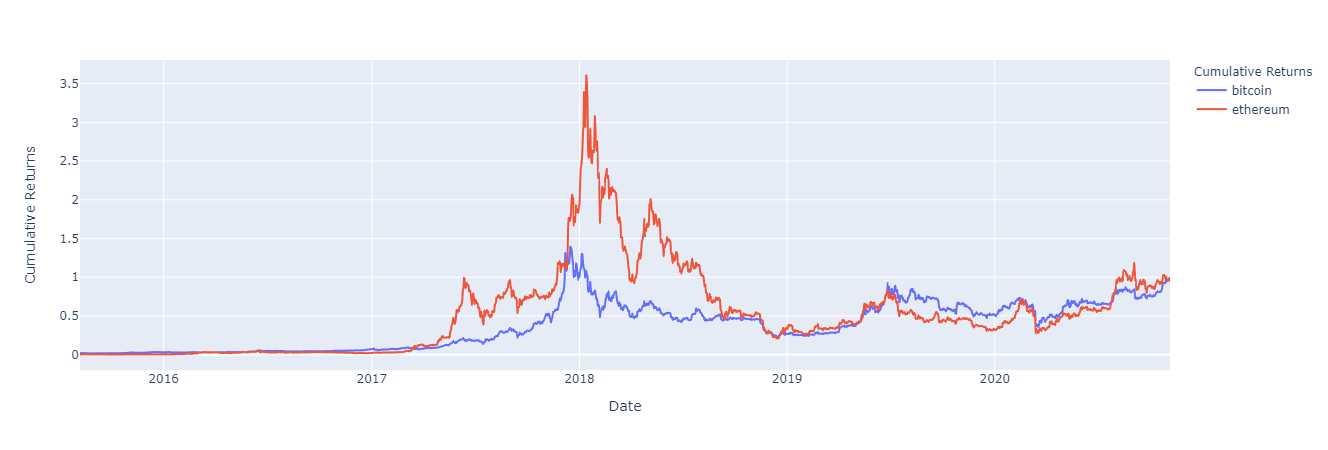

In [108]:
# df = cumulative_returns_dataframe(history_df=history_df, ticker='bitcoin', ticker_header="Ticker", price_header="Price")
# df
pivot_price_df = pivot_price_dataframe(history_df=history_df, ticker_list = list(history_df["Ticker"].unique()))
cumulative_returns_plot(cumulative_returns_dataframe(pivot_price_df))